# Lid Driven Cavity

<img src="img/problemstellung.png" width=450/>

### Lösungsstrategie

1. Lösen der Impulsgleichung ohne Druckgradient für die vorläufige Geschwindigkeit:<br>
    ∂u/∂t + (u ⋅ ∇) u = ν ∇²u
2. Lösen Sie die Druck-Poisson-Gleichung für den Druck zum nächsten Zeitpunkt:<br>
    ∇²p = ρ/Δt ∇ ⋅ u           
3. Lösen der Geschwindigkeitskorrektur (unter Beachtung der Geschwindigkeitsrandbedingungen):<br>
    u ← u − Δt/ρ ∇ p

<img src="img/Programmablauf.png" width=450/>

### Imports

In [72]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

### Parameter

In [73]:
N_GRIDPOINTS = 41                       # Anzahl Gitterpunkte
DOMAIN_SIZE = 1.                        # Länge des Gebietes
N_ITERATIONS = 500                     # Anzahl Zeitschritte
TIME_STEP_LENGTH = 0.001                # Länge des Zeitschrittes, aufgrund der CFL-Bedingung und der Stabilität
DENSITY = 1.                            # Dichte
KINEMATIC_VISCOSITY = 0.01              # kinematische Viskosität
HORIZONTAL_VELOCITY_TOP = 1.            # Geschwindigkeit oben (Deckel bzw. Wand)

N_PRESSURE_ITERATIONS = 50              # Anzahl Iterationen für den Druck
STABILITY_SAFETY_FACTOR = 0.5           # Sicherheitsfaktor für die Stabilität
ELEMENT_LENGTH = DOMAIN_SIZE / (N_GRIDPOINTS - 1)   # Länge eines Elements

### Funktionen

In [74]:
def central_difference_x(f):
    diff = np.zeros_like(f)
    diff[1:-1, 1:-1] = (f[1:-1, 2:]-f[1:-1, 0:-2]) / (2 * ELEMENT_LENGTH)
    return diff

def central_difference_y(f):
    diff = np.zeros_like(f)
    diff[1:-1, 1:-1] = (f[2:, 1:-1]-f[0:-2, 1:-1]) / (2 * ELEMENT_LENGTH)
    return diff

def laplace(f):
    diff = np.zeros_like(f)
    diff[1:-1, 1:-1] = (f[1:-1, 0:-2]+f[0:-2, 1:-1]-4*f[1:-1, 1:-1]+f[1:-1, 2:]+f[2:, 1:-1]) / (ELEMENT_LENGTH**2)
    return diff

def enforce_boundary_conditions(u, v):
    # Enforce boundary conditions for u
    u[0, :] = 0.0   # bottom boundary
    u[-1, :] = HORIZONTAL_VELOCITY_TOP  # top boundary
    u[:, 0] = 0.0   # left boundary
    u[:, -1] = 0.0  # right boundary
    
    # Enforce boundary conditions for v
    v[0, :] = 0.0   # bottom boundary
    v[-1, :] = 0.0  # top boundary
    v[:, 0] = 0.0   # left boundary
    v[:, -1] = 0.0  # right boundary
    return u, v

def plot_veloctiy_and_pressure(X, Y, p_next, u_next, v_next):
    plt.figure(figsize=(8, 6))
    plt.contourf(X[::2, ::2], Y[::2, ::2], p_next[::2, ::2])
    plt.quiver(X[::2, ::2], Y[::2, ::2], u_next[::2, ::2], v_next[::2, ::2])
    plt.colorbar()

    # Set title and axis labels
    plt.title('Velocity and Pressure Contours')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.xlim((0, 1))
    plt.ylim((0, 1))

    # Show the plot
    plt.show()

### Check Stability

In [75]:
max_time_step = 1/2 * (ELEMENT_LENGTH**2 / KINEMATIC_VISCOSITY)
if TIME_STEP_LENGTH > STABILITY_SAFETY_FACTOR * max_time_step:
    raise RuntimeError("Instabil! Wähle einen kleineren Zeitschritt!")

### Programmablauf

In [76]:
# 0. Initialisierung
x = np.linspace(0.0, DOMAIN_SIZE, N_GRIDPOINTS)
y = np.linspace(0.0, DOMAIN_SIZE, N_GRIDPOINTS)

X, Y = np.meshgrid(x, y)

u = np.zeros_like(X)   # velocity in x direction
v = np.zeros_like(X)   # velocity in y direction
p = np.zeros_like(X)   # pressure

In [77]:
for _ in tqdm(range(N_ITERATIONS)):
    # 0. Initialisierung
    du_dx = central_difference_x(u)
    du_dy = central_difference_y(u)
    dv_dx = central_difference_x(v)
    dv_dy = central_difference_y(v)
    laplace_u = laplace(u)
    laplace_v = laplace(v)
    
    # 1. Lösung Impulsgleichung ohne Druck
    u_tentative = (u + TIME_STEP_LENGTH*(KINEMATIC_VISCOSITY*laplace_u - (u*du_dx + v*du_dy)))
    v_tentative = (v + TIME_STEP_LENGTH*(KINEMATIC_VISCOSITY*laplace_v - (u*dv_dx + v*dv_dy)))
    # 1. Randbedingungen erzwingen
    u_tentative, v_tentative = enforce_boundary_conditions(u_tentative, v_tentative)
    
    du_tentative_dx = central_difference_x(u_tentative)
    dv_tentative_dy = central_difference_y(v_tentative)
    
    # 2. Pressure-Poisson Equation
    # 2. rechte Seite berechnen
    rhs = (DENSITY / TIME_STEP_LENGTH * (du_tentative_dx+dv_tentative_dy))
    
    # 2. Druck Laplace lösen
    for _ in range(N_PRESSURE_ITERATIONS):
        p_next = np.zeros_like(p)
        p_next[1:-1, 1:-1] = 1/4 * (+p[1:-1, 0:-2]+p[0:-2, 1:-1]+p[1:-1, 2:]+p[2:, 1:-1]-ELEMENT_LENGTH**2*rhs[1:-1, 1:-1])
        # 2. Randbedingungen erzwingen
        p_next[:, -1] = p_next[:, -2]   # right boundary (Neumann)
        p_next[0,  :] = p_next[1,  :]   # bottom boundary (Neumann)
        p_next[:,  0] = p_next[:,  1]   # left boundary (Neumann)
        p_next[-1, :] = 0.0             # top boundary (Dirichlet)
        p = p_next
    
    dp_next_dx = central_difference_x(p_next)
    dp_next_dy = central_difference_y(p_next)
    
    # 3. Geschwindigkeit mit Druck korrigieren
    u_next = (u_tentative - TIME_STEP_LENGTH/DENSITY * dp_next_dx)
    v_next = (v_tentative - TIME_STEP_LENGTH/DENSITY * dp_next_dy)
    
    # 3. Randbedingungen erzwingen
    u_next, v_next = enforce_boundary_conditions(u_next, v_next)
    u = u_next
    v = v_next
    p = p_next
            

100%|██████████| 500/500 [00:00<00:00, 805.43it/s]


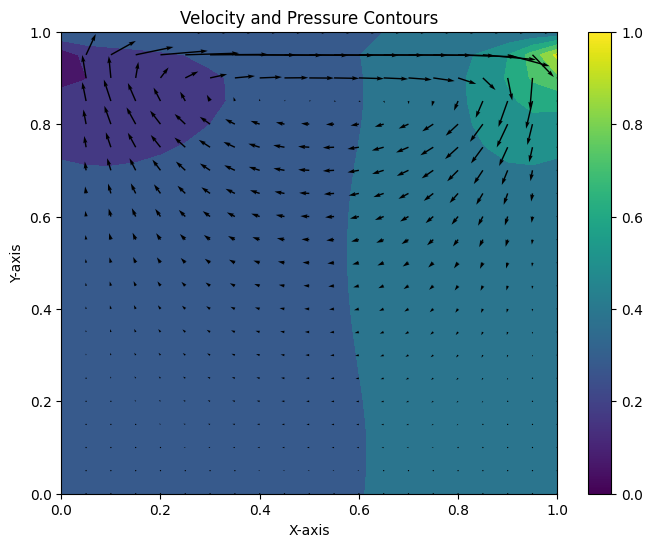

In [78]:
plot_veloctiy_and_pressure(X, Y, p_next, u_next, v_next)

In [80]:
# 0. Initialisierung
x = np.linspace(0.0, DOMAIN_SIZE, N_GRIDPOINTS)
y = np.linspace(0.0, DOMAIN_SIZE, N_GRIDPOINTS)

X, Y = np.meshgrid(x, y)

u = np.zeros_like(X)   # velocity in x direction
v = np.zeros_like(X)   # velocity in y direction
p = np.zeros_like(X)   # pressure

# 0. Initial error
error = 1.0
tolerance = 1e-4
n_iter = 0

# 1. Iteration
while error > tolerance:
    # 0. Initialisierung
    du_dx = central_difference_x(u)
    du_dy = central_difference_y(u)
    dv_dx = central_difference_x(v)
    dv_dy = central_difference_y(v)
    laplace_u = laplace(u)
    laplace_v = laplace(v)
    
    # 1. Lösung Impulsgleichung ohne Druck
    u_tentative = (u + TIME_STEP_LENGTH*(KINEMATIC_VISCOSITY*laplace_u - (u*du_dx + v*du_dy)))
    v_tentative = (v + TIME_STEP_LENGTH*(KINEMATIC_VISCOSITY*laplace_v - (u*dv_dx + v*dv_dy)))
    
    # 1. Randbedingungen erzwingen
    u_tentative, v_tentative = enforce_boundary_conditions(u_tentative, v_tentative)
    
    du_tentative_dx = central_difference_x(u_tentative)
    dv_tentative_dy = central_difference_y(v_tentative)
    
    # 2. Pressure-Poisson Equation
    # 2. rechte Seite berechnen
    rhs = (DENSITY / TIME_STEP_LENGTH * (du_tentative_dx+dv_tentative_dy))
    
    # 2. Druck Laplace lösen
    p_next = p.copy()
    p_error = 1.0
    p_iter = 0
    while p_error > tolerance:
        p_old = p_next.copy()
        p_next[1:-1, 1:-1] = 1/4 * (+p[1:-1, 0:-2]+p[0:-2, 1:-1]+p[1:-1, 2:]+p[2:, 1:-1]-ELEMENT_LENGTH**2*rhs[1:-1, 1:-1])
        # 2. Randbedingungen erzwingen
        p_next[:, -1] = p_next[:, -2]   # right boundary (Neumann)
        p_next[0,  :] = p_next[1,  :]   # bottom boundary (Neumann)
        p_next[:,  0] = p_next[:,  1]   # left boundary (Neumann)
        p_next[-1, :] = 0.0             # top boundary (Dirichlet)
        error = np.linalg.norm(p_next - p_old)
        p = p_next
        p_iter += 1
    
    dp_next_dx = central_difference_x(p_next)
    dp_next_dy = central_difference_y(p_next)
    
    # 3. Geschwindigkeit mit Druck korrigieren
    u_next = (u_tentative - TIME_STEP_LENGTH/DENSITY * dp_next_dx)
    v_next = (v_tentative - TIME_STEP_LENGTH/DENSITY * dp_next_dy)
    
    # 3. Randbedingungen erzwingen
    u_next, v_next = enforce_boundary_conditions(u_next, v_next)
    
    u_old = u
    v_old = v
    p_old = p
    u = u_next
    v = v_next
    p = p_next
    # 4. Error
    error = np.max(np.abs((u - u_old) / TIME_STEP_LENGTH)) + np.max(np.abs((v - v_old) / TIME_STEP_LENGTH)) + np.max(np.abs(p - p_old))
    n_iter += 1
print(f'Overall: {n_iter:3d}. {error:.5f} | Pressure: {p_iter:3d}. {p_error:.5f}')

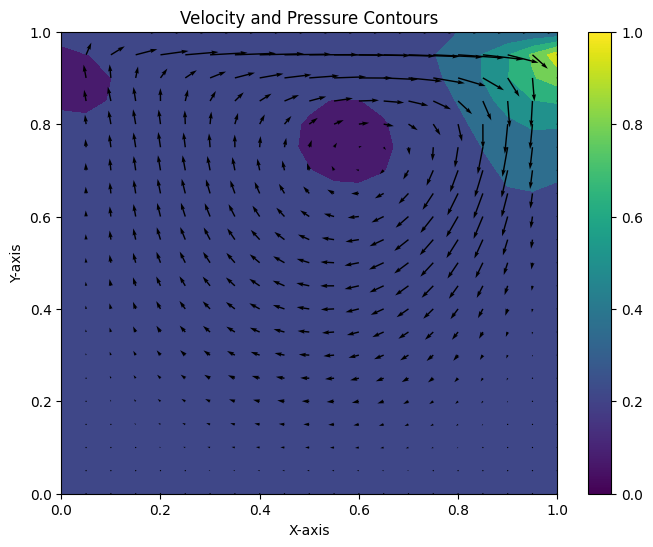

In [ ]:
plot_veloctiy_and_pressure(X, Y, p_next, u_next, v_next)

In [ ]:
# Ghia et al. (1982) - Re = 100
reference_vx_RE_100 = {
    128: 1.00000,
    125: 0.84123,
    124: 0.78871,
    123: 0.73722,
    122: 0.68717,
    109: 0.23151,
    94: 0.00332,
    79: -0.13641,
    64: -0.20581,
    58: -0.21090,
    36: -0.15662,
    22: -0.10150,
    13: -0.06434,
    9: -0.04775,
    8: -0.04192,
    7: -0.03717,
    0: 0.00000
}

# Ghia et al. (1982) - Re = 100
reference_vy_RE_100 = {
    128: 0.00000,
    124: -0.05906,
    123: -0.07391,
    122: -0.08864,
    121: -0.10313,
    116: -0.16914,
    110: -0.22445,
    103: -0.24533,
    64: 0.05454,
    30: 0.17527,
    29: 0.17507,
    20: 0.16077,
    12: 0.12317,
    10: 0.10890,
    9: 0.10091,
    8: 0.09233,
    0: 0.00000
}

In [ ]:
# compare to reference solution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
# ax1 for u
ax1.plot(reference_vx_RE_100.keys(), reference_vx_RE_100.values(), 'o', label='Reference')
ax1.plot(x*128, u_next[:, int(N_GRIDPOINTS/2)], label='Simulation')
ax1.set_xlabel('Vx')
ax1.set_ylabel('u')
ax1.set_title('Vx through Geometric Center of the Cavity')
# ax2 for v
ax2.plot(reference_vy_RE_100.keys(), reference_vy_RE_100.values(), 'o', label='Reference')
ax2.plot(y*128, v_next[int(N_GRIDPOINTS/2), :], label='Simulation')
ax2.set_xlabel('Vy')
ax2.set_ylabel('v')
ax2.set_title('Vy through Geometric Center of the Cavity')
plt.legend()
plt.show()
